In [2]:
import numpy as np

# Save fonts into pdf
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio

import sys
sys.path.append('../../tools/')
import fitting_functions

import matplotlib.colors

import matplotlib.ticker as ticker

import os

In [ ]:
# Load R interface to do statistics
import rpy2.rinterface
%load_ext rpy2.ipython

In [3]:
def exponentialModelConvolved(trange, params, k_cirf):
    dt = trange[1] - trange[0]
    impulse = np.zeros(len(trange))
    impulse[0] = 1./dt*params[-1];
    exp_model = fitting_functions.exponentialModel(trange, params[:-1])
    cirf = fitting_functions.exponentialModel(trange,np.array([1, k_cirf]))
    return dt*np.convolve(exp_model+impulse, cirf)[:len(exp_model)]

def deconvolveEyePos(trange, eye_pos, plant, ind=-1):
    plant_model = fitting_functions.exponentialModel(trange, plant)
    dt = trange[2]-trange[1]
    
    def convMat(signal, m):
        mat = np.zeros((len(signal), m))
        mat[:,0] = signal
        for i in range(1, m):
            mat[i:,i] = signal[:len(signal)-i]
        return mat
    
    if ind == -1:
        ind = len(trange)
    mat = dt*convMat(plant_model, ind)
    optresult = scipy.optimize.lsq_linear(mat, eye_pos, bounds=(0, np.inf))
    f_ = np.zeros(len(trange))
    f_[:len(optresult.x)] = optresult.x
    return f_

def calculateR2(trange, fluo, fit, k_cirf):
    mu = np.mean(fluo)
    sstot = np.sum((fluo - mu)**2)
    sse = np.sum((fluo - exponentialModelConvolved(trange, fit, k_cirf))**2)
    return 1 - sse/sstot 

def correlation(series1, series2):
    series1_mu = np.mean(series1)
    series2_mu = np.mean(series2)
    cov = np.sum((series1 - series1_mu)*(series2-series2_mu))
    return cov/(np.sqrt(np.sum((series1 - series1_mu)**2)*np.sum((series2-series2_mu)**2)))

In [4]:
# Set rcParams
matplotlib.rcParams.update({'font.size': 8, 'axes.linewidth': 0.5, 'xtick.major.width': 0.5, 'xtick.minor.width': 0.5, 
                            'ytick.major.width': 0.5,'ytick.minor.width': 0.5, 'xtick.major.pad':2,'ytick.major.pad':2})
matplotlib.rcParams.update({'font.family':'sans-serif','font.sans-serif':['Arial'], 'mathtext.default':'sf','mathtext.fontset':'custom'})

matplotlib.rcParams.update({'savefig.transparent':True})

In [5]:
file_names = ('110309FISH1', '110609FISH1',
             '111209FISH2', '111309FISH1', '111509FISH1', '111609FISH4')

# Contra fits to determine CIRF time constants

In [9]:
trange = np.arange(0, 2e-3*4097, 2e-3)
r2s_fluos = [] # Calculate R^2 of fits to fluorescence
r_eyepos = [] # Calculate correlation between eye position convolved with CIRF and fluorescence
taus = [] # Collect CIRF (inverse) time constants

# Set to True to produce plots showing comparison of eye position convolved with CIRF and fluorescence
make_figure_eye = False
if make_figure_eye:
    if not os.path.isdir('plots'):
        os.makedirs('plots/eye')

# Set to True to produce plots showing quality of CIRF fits        
make_figure_fluo = False
if make_figure_fluo:
    if not os.path.isdir('plots'):
        os.makedirs('plots/fluo')

for i in range(len(file_names)):
    data_file = sio.loadmat('../../data/cells/fluo/'+file_names[i]+'.mat')
    fluo_ipsi = data_file['FluoIpsi']
    fluo_contra = data_file['FluoContra']
    eyepos_ipsi = data_file['ipsiSTAE6smoo'][0]
    eyepos_contra = data_file['contraSTAE6smoo'][0]
    
    saccade_end = len(eyepos_contra) - 3072
    
    fluo_ipsi_means = np.mean(fluo_ipsi[1537-1000:1537-500, :], axis=0)
    fluo_contra_means = np.mean(fluo_contra[1537+2000:1537+2500, :], axis=0)
    fluo_means = np.minimum(fluo_ipsi_means, fluo_contra_means)
    
    fits_file = sio.loadmat('cirf/results/'+file_names[i]+'_contra.mat')
    best_cirf_fits = fits_file['fits']
    best_cirf_r2s = fits_file['r2'][0]
    
    r2s_fluos.append(best_cirf_r2s)
    taus.append(best_cirf_fits[:,1])
    
    # for plotting:
    num_cells = best_cirf_fits.shape[0]
    num_rows = int(np.ceil(num_cells/4))
    
    r_eyepos_temp = np.zeros(num_cells)
    
    
    if make_figure_eye:
        plt.figure(figsize=(1.6*4,1.5*num_rows));
        
    for k in range(best_cirf_fits.shape[0]):
        
        cirf_filter = fitting_functions.exponentialModel(trange, best_cirf_fits[k,:])
        cirf_conv_eye_pos = 2e-3*np.convolve(eyepos_contra, cirf_filter)[:len(cirf_filter)]
        fluo_data = fluo_contra[saccade_end-1000:,k]-fluo_means[k]
        
        r_eyepos_temp[k] = correlation(fluo_data, cirf_conv_eye_pos[saccade_end-1000:])
        
        if make_figure_eye:
            ax = plt.subplot(num_rows, 4, k+1)
            ax.plot(trange[saccade_end-1000:]-trange[saccade_end], fluo_data)
            ax2 = ax.twinx()
            ax2.plot(trange[saccade_end-1000:]-trange[saccade_end], cirf_conv_eye_pos[saccade_end-1000:], c='C1')
            plt.title(r'$r$ = %.3f' % (r_eyepos_temp[k]))

            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax2.spines['top'].set_visible(False)
            ax2.spines['left'].set_visible(False)
    if make_figure_eye:
        plt.tight_layout()
        plt.savefig('plots/eye/'+file_names[i]+'_contra.pdf')
        
    r_eyepos.append(r_eyepos_temp)     
    
    if make_figure_fluo:
        plt.figure(figsize=(1.6*4,1.5*num_rows))
        for k in range(num_cells):
            ax = plt.subplot(num_rows, 4, k+1)
            fluo_data = fluo_contra[saccade_end-500:,k]-fluo_means[k]
            plt.plot(trange[saccade_end-500:]-trange[saccade_end], fluo_data)
            plt.plot(trange[saccade_end:]-trange[saccade_end], fitting_functions.exponentialModel(trange[:-saccade_end], best_cirf_fits[k,:]))
            ylims = ax.get_ylim()
            plt.plot([0,]*2, ylims, '--')
            plt.xlabel('Time after saccade peak (s)')
            plt.ylabel(r'$\Delta$F/F - baseline')

            plt.title(r'$R^2$ = %.3f' % (best_cirf_r2s[k]))

            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

        plt.tight_layout()
        plt.savefig('plots/fluo/'+file_names[i]+'_cirfs.pdf')

/Users/jbhasin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars


### Statistics regarding cells that exceed fit quality and correlation thresholds:

In [14]:
taus_good = []
total_good = 0
total = 0
for i in range(len(file_names)):
    cell_inds_temp = np.where((r2s_fluos[i] >= 0.5)*(r_eyepos[i] > 0.5))[0]
    taus_good.append(taus[i][cell_inds_temp])
    print('Fish %d: %d/%d' % (i+1, len(cell_inds_temp), len(r2s_fluos[i])))
    total += len(r2s_fluos[i])
    total_good +=len(cell_inds_temp)
print('Total: %d/%d' % (total_good, total))

Fish 1: 33/44
Fish 2: 21/23
Fish 3: 15/17
Fish 4: 44/51
Fish 5: 36/41
Fish 6: 17/19
Total: 166/195


In [11]:
taus_flattened = np.concatenate(taus_good)

In [13]:
np.median(1/taus_flattened)

1.5214048181044353

Text(0, 0.5, 'Count')

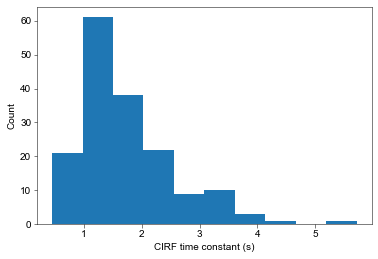

In [12]:
plt.hist(1/taus_flattened)
plt.xlabel('CIRF time constant (s)')
plt.ylabel('Count')

# Ipsi fits

In [6]:
best_fits_ipsi = [] # fit, fish num, cell num, R^2
fluos_ipsi = []
ss_ratio = []
ipsi_peaks = []
r2s_ipsi = []

ss_ratio_cutoff = 7e-3
T_start = 125
persistences = []
eye_persistences = np.zeros(len(file_names))
persistence_ratios = []

for i in range(len(file_names)):
    filename = file_names[i]
    data_file = sio.loadmat('../../data/cells/fluo/'+filename+'.mat')
    fluo_ipsi = data_file['FluoIpsi']
    eyepos_ipsi = data_file['ipsiSTAE6'][0]-data_file['null_pos'][0][0]
    fluo_contra = data_file['FluoContra']
    
    fluo_ipsi_means = np.mean(fluo_ipsi[1537-1000:1537-500,:], axis=0)
    fluo_contra_means= np.mean(fluo_contra[1537+2000:1537+2500,:], axis=0)
    fluo_means = np.minimum(fluo_ipsi_means, fluo_contra_means)

    ipsi_peak = np.argmax(eyepos_ipsi)
    ipsi_peaks.append(ipsi_peak)
    trange = np.arange(0, 2e-3*4097, 2e-3)

    fit_file_ipsi = sio.loadmat('fit/results/'+filename+'_ipsi.mat')
    best_fits_ipsi_fish = fit_file_ipsi['fits'][0]
    k_cirf = fit_file_ipsi['k_cirf'][0]
    indices = fit_file_ipsi['indices'][0]
    
    eye_persistences[i] = np.sum(eyepos_ipsi[ipsi_peak+T_start:]/eyepos_ipsi[ipsi_peak+T_start])/len(eyepos_ipsi[ipsi_peak+T_start:])
    
    for k in range(len(best_fits_ipsi_fish)):
        ind = indices[k]
        best_fit_ = best_fits_ipsi_fish[k][0]
        r2 = calculateR2(trange[:-ipsi_peak], fluo_ipsi[ipsi_peak:,ind]-fluo_means[ind],best_fit_, k_cirf[k])
        fluo = fluo_ipsi[:,ind]-fluo_means[ind]
        model = exponentialModelConvolved(trange[:-ipsi_peak],best_fit_, k_cirf[k])
        ss_ratio_ = np.sum((fluo[ipsi_peak:]-model)**2)/np.sum((fluo[ipsi_peak:])**2)
        
        best_fits_ipsi.append({'fit':best_fit_,'fish': i,'cell': indices[k],'k': k, 'k_cirf': k_cirf[k],'ss_ratio': ss_ratio_, 'ipsi_peak':ipsi_peak})
        fluos_ipsi.append({'fluo':fluo})
        ss_ratio.append(ss_ratio_)
        r2s_ipsi.append(r2)
        
        trange_fits = trange[ipsi_peak:]-trange[ipsi_peak]
        fr_model = fitting_functions.exponentialModel(trange_fits, best_fit_[:-1])
        fr = fitting_functions.exponentialModel(trange[:-ipsi_peak], best_fit_[:-1])
        fr_p = np.sum(fr[T_start:]/fr[T_start])/len(fr[T_start:])
        persistences.append(fr_p)
        persistence_ratios.append(fr_p/eye_persistences[i])

In [7]:
ss_ratio = np.array(ss_ratio)

Text(0, 0.5, 'Cumulative probability')

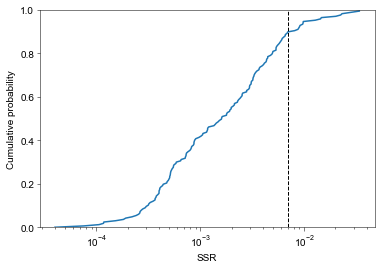

In [43]:
plt.xscale('log')
plt.plot(np.sort(ss_ratio), np.arange(len(ss_ratio))/len(ss_ratio))
plt.plot([7e-3,]*2, [0,1],'k--', lw=1)
plt.ylim([0,1])
plt.xlabel('SSR')
plt.ylabel('Cumulative probability')

In [42]:
np.sum(ss_ratio < 7e-3)

151

In [8]:
ss_ratio_sort_inds = np.argsort(ss_ratio)

Determine the best, median and worst fits (by sum of squares ratio) to plot in Fig 8B:

In [48]:
for ind in [0, int(0.5*151)-1, 151-1]:
    j = ss_ratio_sort_inds[ind]
    print('SSR: %.3e, fish %d, cell %d (%d)' % (ss_ratio[j], best_fits_ipsi[j]['fish'], best_fits_ipsi[j]['cell'], best_fits_ipsi[j]['k']))

SSR: 3.982e-05, fish 1, cell 19 (17)
SSR: 1.163e-03, fish 0, cell 29 (22)
SSR: 6.947e-03, fish 4, cell 17 (15)


In [50]:
T_start = 125
trange = np.arange(0, 2e-3*4097, 2e-3)

## Figure 8B: examples of fits to fluorescence data

### Best

In [61]:
i = ss_ratio_sort_inds[0]
ipsi_peak = best_fits_ipsi[i]['ipsi_peak']
trange_fits = trange[ipsi_peak:]-trange[ipsi_peak]
conv_model = exponentialModelConvolved(trange[:-ipsi_peak], best_fits_ipsi[i]['fit'], best_fits_ipsi[i]['k_cirf'])
fr_model = fitting_functions.exponentialModel(trange_fits, best_fits_ipsi[i]['fit'][:-1])

#### Fluorescence fit

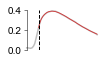

In [62]:
plt.figure(figsize=(1.3, 0.65))
plt.plot(trange[ipsi_peak-500:]-trange[ipsi_peak], fluos_ipsi[i]['fluo'][ipsi_peak-500:], label='Fluo', c=(0.75, 0.75, 0.75, 1), clip_on=False)
plt.plot(trange_fits, conv_model, c='C3', lw=0.75, clip_on=False)

plt.plot([0,]*2, [0, 0.4], 'k--', lw=1)


ax = plt.gca()
plt.xlim([-1, 5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.ylim([0, 0.4])


ax.spines['bottom'].set_visible(False)
ax.set_xticks([])


plt.subplots_adjust(left=0.21, bottom=0.1, right=0.98, top=0.96)

#### Firing rate

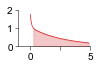

In [63]:
plt.figure(figsize=(1.3, 0.65))

plt.plot(trange_fits, fr_model/fr_model[T_start],
        color='C3', lw=0.75)
plt.fill_between(trange_fits[T_start:], fr_model[T_start:]/fr_model[T_start],
        color='C3', alpha=0.25)

ax = plt.gca()
plt.xlim([-1, 5])
plt.ylim([0,2])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks([0, 1, 2])
ax.set_yticklabels([0, 1, 2])

ax.set_xticks(np.linspace(0,5,3))
ax.set_xticklabels([0, '', 5])
         
plt.subplots_adjust(left=0.21, bottom=0.18, right=0.98, top=0.96)  

### Median

In [64]:
i = ss_ratio_sort_inds[int(0.5*151)-1]
ipsi_peak = best_fits_ipsi[i]['ipsi_peak']
trange_fits = trange[ipsi_peak:]-trange[ipsi_peak]
conv_model = exponentialModelConvolved(trange[:-ipsi_peak], best_fits_ipsi[i]['fit'], best_fits_ipsi[i]['k_cirf'])
fr_model = fitting_functions.exponentialModel(trange_fits, best_fits_ipsi[i]['fit'][:-1])

#### Fluorescence fit

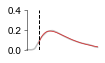

In [65]:
plt.figure(figsize=(1.3, 0.65))
plt.plot(trange[ipsi_peak-500:]-trange[ipsi_peak], fluos_ipsi[i]['fluo'][ipsi_peak-500:], label='Fluo', c=(0.75, 0.75, 0.75, 1), clip_on=False)
plt.plot(trange_fits, conv_model, c='C3', lw=0.75, clip_on=False)

plt.plot([0,]*2, [0, 0.4], 'k--', lw=1)


ax = plt.gca()
plt.xlim([-1, 5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.ylim([0, 0.4])


ax.spines['bottom'].set_visible(False)
ax.set_xticks([])


plt.subplots_adjust(left=0.21, bottom=0.1, right=0.98, top=0.96)

#### Firing rate

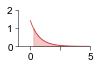

In [66]:
plt.figure(figsize=(1.3, 0.65))

plt.plot(trange_fits, fr_model/fr_model[T_start],
        color='C3', lw=0.75)
plt.fill_between(trange_fits[T_start:], fr_model[T_start:]/fr_model[T_start],
        color='C3', alpha=0.25)

ax = plt.gca()
plt.xlim([-1, 5])
plt.ylim([0,2])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks([0, 1, 2])
ax.set_yticklabels([0, 1, 2])

ax.set_xticks(np.linspace(0,5,3))
ax.set_xticklabels([0, '', 5])
         
plt.subplots_adjust(left=0.21, bottom=0.18, right=0.98, top=0.96)  

### Worst

In [72]:
i = ss_ratio_sort_inds[151-1]
ipsi_peak = best_fits_ipsi[i]['ipsi_peak']
trange_fits = trange[ipsi_peak:]-trange[ipsi_peak]
conv_model = exponentialModelConvolved(trange[:-ipsi_peak], best_fits_ipsi[i]['fit'], best_fits_ipsi[i]['k_cirf'])
fr_model = fitting_functions.exponentialModel(trange_fits, best_fits_ipsi[i]['fit'][:-1])

#### Fluorescence fit

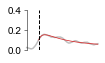

In [74]:
plt.figure(figsize=(1.3, 0.65))
plt.plot(trange[ipsi_peak-500:]-trange[ipsi_peak], fluos_ipsi[i]['fluo'][ipsi_peak-500:], label='Fluo', c=(0.75, 0.75, 0.75, 1), clip_on=False)
plt.plot(trange_fits, conv_model, c='C3', lw=0.75, clip_on=False)

plt.plot([0,]*2, [0, 0.4], 'k--', lw=1)


ax = plt.gca()
plt.xlim([-1, 5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.ylim([0, 0.4])


ax.spines['bottom'].set_visible(False)
ax.set_xticks([])


plt.subplots_adjust(left=0.21, bottom=0.1, right=0.98, top=0.96)

#### Firing rate

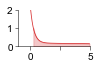

In [75]:
plt.figure(figsize=(1.3, 0.65))

plt.plot(trange_fits, fr_model/fr_model[T_start],
        color='C3', lw=0.75)
plt.fill_between(trange_fits[T_start:], fr_model[T_start:]/fr_model[T_start],
        color='C3', alpha=0.25)

ax = plt.gca()
plt.xlim([-1, 5])
plt.ylim([0,2])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks([0, 1, 2])
ax.set_yticklabels([0, 1, 2])

ax.set_xticks(np.linspace(0,5,3))
ax.set_xticklabels([0, '', 5])
         
plt.subplots_adjust(left=0.21, bottom=0.18, right=0.98, top=0.96)  

## Show all fits

In [ ]:
num_rows = int(np.ceil(len(best_fits)/4))
plt.figure(figsize=(1.6*4,1.5*num_rows))
for i in range(len(best_fits)):
    plt.subplot(num_rows, 4, i+1)
    j = ss_ratio_sort_inds[i]
    ipsi_peak = best_fits_ipsi[j]['ipsi_peak']
    plt.plot(trange-trange[ipsi_peak], fluos_ipsi[j]['fluo'])
    plt.plot([0,]*2, [np.min(fluos_ipsi[j]['fluo']), np.max(fluos_ipsi[j]['fluo'])], c='k', lw=1, ls='--')
    plt.plot(trange[:-ipsi_peak], exponentialModelConvolved(trange[:-ipsi_peak], best_fits_ipsi[j]['fit'], best_fits_ipsi[j]['k_cirf']))
    plt.title('SSR = %.3e' % (ss_ratio[j]))
plt.tight_layout()

In [9]:
persistences = np.array(persistences)[ss_ratio < 7e-3]
persistence_ratios = np.array(persistence_ratios)[ss_ratio < 7e-3]

## Figure 8C: firing rate persistence

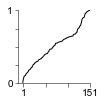

In [80]:
plt.figure(figsize=(1.3, 1.3))
# plt.yscale('log')
aucs_inds = np.argsort(persistences)
plt.plot(np.arange(len(persistences)), persistences[aucs_inds], c='k', lw=1)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.set_xticks(np.linspace(1, 151, 4))
ax.set_xticklabels([1, '', '', 151])
plt.xlim([-10, 151])

ax.set_yticks(np.linspace(0, 1, 5))
ax.set_yticklabels([0, '', '', '', 1])
plt.ylim([0, 1])

plt.subplots_adjust(left=0.21, bottom=0.18, top=0.96, right=0.98)

## Figure 8D: histogram of persistence ratios

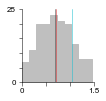

In [10]:
plt.figure(figsize=(1.3, 1.3))

plt.hist(persistence_ratios, facecolor=(0.75, 0.75, 0.75, 1), edgecolor=(0.75, 0.75, 0.75, 1), bins=10, clip_on=False)

plt.plot([1.05542,]*2, [0, 25], c='C9', lw=0.5)
plt.plot([0.71387,]*2, [0, 25], c='C3', lw=0.5)
plt.plot([np.median(persistence_ratios)]*2, [0, 25], c=(0.25, 0.25, 0.25, 1), lw=0.5)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylim([0, 25])
plt.xlim([0, 1.5])
ax.set_yticks(np.linspace(0,25,6))
ax.set_yticklabels([0, '', '',  '','',25])
ax.set_xticks([0, 0.5, 1, 1.5])
ax.set_xticklabels([0, '', '',1.5])

plt.subplots_adjust(left=0.21, bottom=0.18, right=0.98, top=0.96)

In [92]:
np.mean(persistence_ratios), np.std(persistence_ratios)

(0.7069970183848395, 0.33396257018656844)

In [82]:
np.median(persistence_ratios)

0.6885368368494117

In [91]:
np.sum(persistence_ratios<1), "{:.1f}%".format((np.sum(persistence_ratios<1)/151*100))

(122, '80.8%')

## Statistics

In [ ]:
%%R -i persistences -i eye_persistences
wilcox.test(eye_persistences, persistences, alternative="two.sided", paired=FALSE, exact=TRUE)

W = 731, p-value = 0.01106

alternative hypothesis: true location shift is not equal to 0